In [232]:
import pandas as pd

hn = pd.read_csv("hero-network.csv")
e = pd.read_csv("edges.csv")
nodes = pd.read_csv("nodes.csv")

import re

def cleaning(string):
    #Pattern for backlash in last position
    pattern = "\/$" 
    newS = re.sub(pattern, "", string)

    #pattern for space in last position
    pattern =  " $"
    newS = re.sub(pattern, "", newS)
    
    return newS

#Extract all the names from the edges
vecHeroRight = e.hero.unique()
cleanHeroRight = set(map(cleaning, vecHeroRight))

#Extract all the names of the heroes that might be wrong (col hero1)
vecHeroWrong = hn.hero1.unique()
newVecHeroWrong = set(map(cleaning, vecHeroWrong))

#Extract all the names of the heroes that might be wrong (col hero2)
vecHeroWrong2 = hn.hero2.unique()
newVecHeroWrong2 = set(map(cleaning, vecHeroWrong2))

#Merge 
mergeHeroWrong = newVecHeroWrong.union(newVecHeroWrong2)

#TODO: convert into function

#Dic to clean hero-network
dic = {}
#Iterate over the wrong hero names
for x in mergeHeroWrong:
    
    #Iterate over the right hero names
    for y in cleanHeroRight:
        dic[x] = x
        if x in y:
            dic[x] = y
            break


#Dic to clean nodes

# heroEdge = set(map(cleaning, e.hero.unique()))
# heroNode = set(map(cleaning, nodes.node.unique()))
# dic2 = {}
# #Iterate over the wrong hero names
# for x in heroNode:
    
#     #Iterate over the right hero names
#     for y in heroEdge:
        
#         dic2[x] = x
#         if x in y:
#             k = len(y)
#             dic2[x] = y,k

# #view for comic
# tempComic = nodes[nodes.type == "comic"]
# for x in set(tempComic.node):
#     dic2[x] = x

#Clean the values in both columns
hn.hero1 = hn.hero1.apply(lambda row: cleaning(row))
hn.hero2 = hn.hero2.apply(lambda row: cleaning(row))

#Replace the wrong names with the right ones
hn["hero1"] = hn.hero1.apply(lambda row: dic[row])
hn["hero2"] = hn.hero2.apply(lambda row: dic[row])

#Clean the values in nodes.node
nodes.node =  nodes.node.apply(lambda row: cleaning(row))

#Replae the wrong names with the right ones
# nodes["node"] = nodes.node.apply(lambda row: dic2[row])

#Clean the values in edges.hero
e.hero =  e.hero.apply(lambda row: cleaning(row))

#remove duplicates rows from hero network
hn_final = hn[hn.hero1 != hn.hero2]

In [60]:
import numpy as np
import matplotlib.pyplot as plt

## First Graph

In [61]:
hn_final = hn_final.sort_values(by = ['hero1', 'hero2']).reset_index(drop = True)

In [62]:
mask = hn_final['hero1'] > hn_final['hero2']

# swap the values in those rows
hn_final.loc[mask, ['hero1', 'hero2']] = hn_final.loc[mask, ['hero2', 'hero1']].values

In [63]:
hn_temp = hn_final
hn_final['Number'] = hn_final.groupby(['hero1', 'hero2']).cumcount().add(1)


In [64]:
hn_final = hn_final.sort_values(by = 'Number', ascending = False)

In [65]:
hn_final = hn_final.drop_duplicates(subset = ['hero1', 'hero2'], keep = 'first')

In [66]:
hn_final = hn_final.groupby(['hero1', 'hero2'], sort = False).agg({'hero1' : 'first', 'hero2' : 'first', 'Number': 'sum'}).reset_index(drop = True)

In [67]:
hn_final['Number'] = hn_final['Number'].apply(lambda x: 1/x)

In [68]:
hn_final = pd.merge(hn_temp, hn_final, on=['hero1','hero2'])

In [69]:
hn_final.drop('Number_x', axis=1, inplace= True)

In [70]:
hn_final.rename(columns={"Number_y":"weight"}, inplace=True)
hn_final.drop_duplicates(inplace=True)
hn_final.sort_values(by="weight")

,hero1,hero2,weight
414710,MISS AMERICA/MADELIN,PATRIOT/JEFF MACE,0.000528
307496,HUMAN TORCH/JOHNNY S,THING/BENJAMIN J. GR,0.001344
304501,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R,0.001403
427788,MR. FANTASTIC/REED R,THING/BENJAMIN J. GR,0.001412
319550,INVISIBLE WOMAN/SUE,MR. FANTASTIC/REED R,0.001427
...,...,...,...
321416,INVISIBLE WOMAN/SUE,"RUIZ, RHYTHM",1.000000
321415,INVISIBLE WOMAN/SUE,RUBY,1.000000
321390,INVISIBLE WOMAN/SUE,"ROSEN, WALTER",1.000000
321658,INVISIBLE WOMAN/SUE,SHANG-CHI,1.000000


Il seguente è il grafo con il collegamento tra gli eroi con il relativo peso dato dall'inverso del numero di volte che hanno collaborato

In [71]:
import networkx as nx

In [72]:
a = hn_final.to_numpy()

G = nx.Graph()

In [73]:
G.add_weighted_edges_from(a)

In [74]:
#uncomment to try
#G.edges("MISS AMERICA/MADELIN")

In [75]:
nx.get_edge_attributes(G, 'weight')

{('24-HOUR MAN/EMMANUEL', 'FROST, CARMILLA'): 1.0,
 ('24-HOUR MAN/EMMANUEL', 'KILLRAVEN/JONATHAN R'): 1.0,
 ('24-HOUR MAN/EMMANUEL', "M'SHULLA"): 1.0,
 ('24-HOUR MAN/EMMANUEL', "G'RATH"): 1.0,
 ('24-HOUR MAN/EMMANUEL', 'OLD SKULL'): 1.0,
 ('FROST, CARMILLA', 'ABRAXAS'): 0.3333333333333333,
 ('FROST, CARMILLA', 'ADAM 3,031'): 0.25,
 ('FROST, CARMILLA', 'ATALON'): 0.25,
 ('FROST, CARMILLA', 'DEVOURER'): 1.0,
 ('FROST, CARMILLA', 'EVE 3,031'): 0.25,
 ('FROST, CARMILLA', 'ANGEL/WARREN KENNETH'): 1.0,
 ('FROST, CARMILLA', 'BROTHER AXE'): 1.0,
 ('FROST, CARMILLA', 'DEATHRAVEN/JOSHUA RA'): 0.5,
 ('FROST, CARMILLA', 'FOROPULIST'): 0.5,
 ('FROST, CARMILLA', 'GROK'): 0.07692307692307693,
 ('FROST, CARMILLA', 'HIGH OVERLORD'): 0.16666666666666666,
 ('FROST, CARMILLA', 'KILLRAVEN/JONATHAN R'): 0.05555555555555555,
 ('FROST, CARMILLA', "M'SHULLA"): 0.05555555555555555,
 ('FROST, CARMILLA', 'MELONIE'): 0.5,
 ('FROST, CARMILLA', 'MILLER, JENETTE'): 1.0,
 ('FROST, CARMILLA', 'MINT JULEP'): 0.333333333

## Second Graph

In [76]:
e.head()

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


In [77]:
nodes.head()

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


In [78]:
hero = nodes[nodes.type=="hero"]
hero.drop("type", axis=1, inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_16300\2443088000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hero.drop("type", axis=1, inplace=True)


In [79]:
nodes[nodes.node == "SPIDER-MAN/PETER PARKERKER"]

,node,type
14618,SPIDER-MAN/PETER PARKERKER,hero


In [80]:
nodes.loc[14618].node = "SPIDER-MAN/PETER PARKER"
nodes[nodes.node == "SPIDER-MAN/PETER PARKER"]

,node,type
14618,SPIDER-MAN/PETER PARKER,hero


In [81]:
#Create empty graph
G2 = nx.Graph()

#Preprocess info for heroes
hero = nodes[nodes.type=="hero"]
hero.drop("type", axis=1, inplace=True)

#Add hero nodes
G2.add_nodes_from(hero.node, type= "hero")

#Preprocess info for comic
comic = nodes[nodes.type=="comic"]
comic.drop("type", axis=1, inplace=True)

#Add comic nodes
G2.add_nodes_from(comic.node, type= "comic")

#Preprocess info for edges
a = e.to_numpy()

#Add edges
G2.add_edges_from(a)

C:\Users\user\AppData\Local\Temp\ipykernel_16300\2569478207.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hero.drop("type", axis=1, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_16300\2569478207.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comic.drop("type", axis=1, inplace=True)


In [82]:
# TODO: elimina avvisi

## Functionality 1

In [83]:
def findNHeroes(data: pd.DataFrame, N: int) -> pd.DataFrame:
    NHeroes = list(data.groupby(by="hero")
    .count()                                            #count number of repetition
    .sort_values(by="comic", ascending=False)           #Sort values by "comic"
    .head(N)                                            #get top N
    .reset_index()                                      #reset index
    .hero)                                              #get only the names of our heroes
    return NHeroes

In [84]:
def findNNodes(graph, typeG, edges):
    #take the number of nodes
    numberNodes = len(graph)
    if typeG == "2":
        dic = dict(graph.nodes(data="type"))
        numberComic = len([k for k, v in dic.items() if v == "comic"])
        numberHero = len([k for k, v in dic.items() if v == "hero"])
        numberNodes = (numberComic, numberHero)
    return numberNodes

In [85]:
def findNCollaboration(graph, typeG):
    #If graph is of type 1
    if typeG == 1:
        return list(graph.degree())

    #if graph is of type 2
    if typeG == 2:
        
        #select all the nodes that are comic and take the degree
        dic = dict(G2.nodes(data="type"))
        return list(graph.degree([k for k, v in dic.items() if v == "comic"]))


In [95]:
def findNetworksHub(graph, typeG, degreeDist):
    if typeG == 1:
        tempDegree = dict(graph.degree())

    #if graph of type 2
    if typeG == 2:

        #we take only the degree for the comics
        tempDegree = dict(graph.degree([k for k, v in dic.items() if v == "comic"]))

    #select the threshold
    threshold = np.quantile(list(tempDegree.values()), 0.95)
    
    #Select nodes based on threshold
    nodes = [k for k, v in tempDegree.items() if v > threshold ]

    return nodes


In [87]:
def functionality1(graph, typeG, edges, NHeroes = None):
    
    #select subGraph if specified
    if NHeroes != None:
        
        #Then we find the top N Nodes/Heroes
        N = NHeroes
        topN = findNHeroes(edges, N)

        if typeG == 1:
            #Create the new subgraph from the topN heroes
            graph = graph.subgraph(topN)
        else:
            #take the subset of the graph with all the relatives edges and nodes
            graph = graph.edge_subgraph(graph.edges(topN))

    #1st point: number of nodes in network
    numberNodes = findNNodes(graph, typeG, edges)

    #2nd and 3rd point (based on typeG): number of collaboration/number of heroes
    nCollaboration = findNCollaboration(graph, typeG)

    #4th point: network density
    density = nx.density(graph)

    #5th point: degree distribution
    degreeDist = nx.degree_histogram(graph)

    #6th point: average degree
    tempDegree = dict(graph.degree()).values()
    averageDegree = round(sum(tempDegree)/len(tempDegree),2)

    #7th point: networks hubs
    hubs = findNetworksHub(graph, typeG, degreeDist)

    #8th point: sparse or dense?
    isDense = True if density > 0.5 else False

            
            

    return numberNodes, nCollaboration, density, degreeDist, averageDegree, hubs, isDense

## Visualization 1

In [96]:
numberNodes, nCollaboration, density, degreeDist, averageDegree, hubs, isDense = functionality1(G,1, e, 120)

### A table containing the following general information about the graph:

- Number of nodes in the network
- Density of the network
- Average degree of the network
- Whether the network is sparse or dense

In [98]:
from tabulate import tabulate
col_names = ["Number of nodes","Density","Average degree","Dense"]
data = {'Number of nodes':[numberNodes], 'Density':[density],'Average degree':[averageDegree],'Dense':[isDense]}
print(tabulate(data, headers=col_names,  tablefmt="fancy_grid"))

╒═══════════════════╤═══════════╤══════════════════╤═════════╕
│   Number of nodes │   Density │   Average degree │ Dense   │
╞═══════════════════╪═══════════╪══════════════════╪═════════╡
│               113 │  0.765961 │            85.79 │ True    │
╘═══════════════════╧═══════════╧══════════════════╧═════════╛


### A table that lists the network's hubs

In [99]:
from tabulate import tabulate
col_names = ["Hubs"]
data = {'Hubs': hubs}
print(tabulate(data, headers=col_names,  tablefmt="fancy_grid"))

╒═════════════════════════╕
│ Hubs                    │
╞═════════════════════════╡
│ CYCLOPS/SCOTT SUMMER    │
├─────────────────────────┤
│ MR. FANTASTIC/REED R    │
├─────────────────────────┤
│ HUMAN TORCH/JOHNNY S    │
├─────────────────────────┤
│ SPIDER-MAN/PETER PARKER │
╘═════════════════════════╛


### A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1) / A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

In [100]:
sort_col = sorted(nCollaboration, key=lambda item: item[1], reverse=True)[:30]

In [101]:
#TODO: add theme to plots
#TODO: add figsize

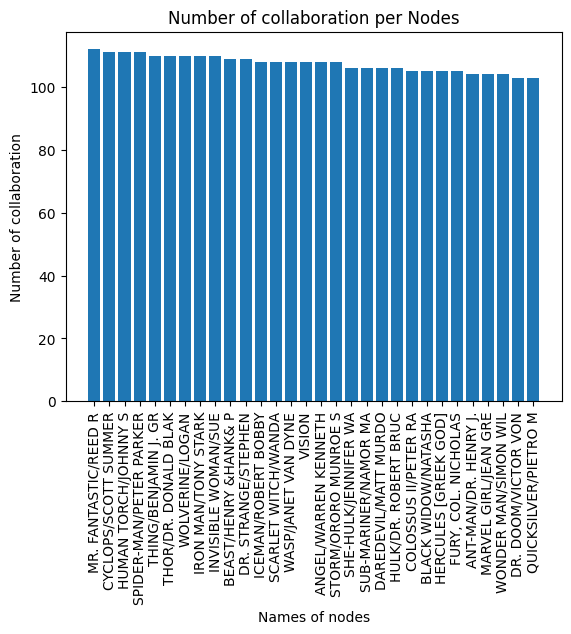

In [102]:
plt.bar(*zip(*sort_col))
plt.xticks(rotation=90)
plt.title("Number of collaboration per Nodes")
plt.ylabel("Number of collaboration")
plt.xlabel("Names of nodes")
plt.show()

### A plot depicting the degree distribution of the network

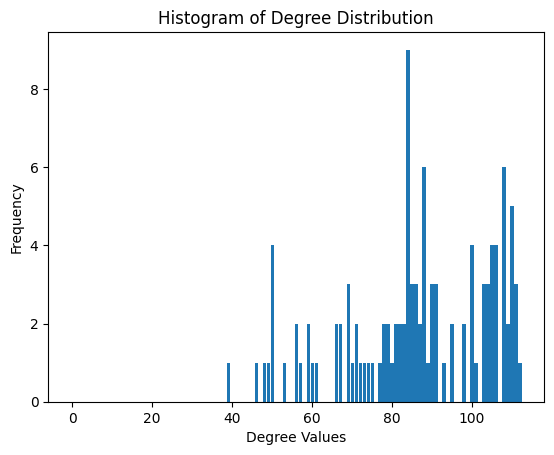

In [103]:
plt.bar(range(len(degreeDist)), degreeDist)
plt.title("Histogram of Degree Distribution")
plt.xlabel("Degree Values")
plt.ylabel("Frequency")
plt.show()

## Functionality 3

In [104]:
def writePath(prev, source, target):
    myList = []
    notFound = True
    myList += [target]
    if prev[target] == np.nan:
        return "Path Not Found!"
    while notFound:
        myList += [prev[myList[-1]]]
        if myList[-1] == source:
            notFound= False
    myList.reverse()
    return myList


In [105]:
#TODO: gestisci il caso in cui non siano connessi
def findShortestPath(graph, couple):
    source = couple[0]
    target = couple[1]

    nodesNotVisited = set(graph.nodes())
    
    #Create dist dictionary with np.inf as values
    dist = {node:np.inf for node in nodesNotVisited}
    #Create prev dictioary with np.nan as values
    prev = {node:np.nan for node in nodesNotVisited}

    #inizialize source
    dist[source] = 0

    myMin = min(dist.values())
    while nodesNotVisited:
        nodes = [x for x, y in dist.items() if y == myMin and x in nodesNotVisited]

        for node in nodes:
            nodesNotVisited.remove(node)
            neighbors = list(G2.neighbors(node))
            for neighbor in neighbors:
                if neighbor in nodesNotVisited:
                    newDist = dist[node] + 1
                    if newDist < dist[neighbor]:
                        dist[neighbor] = newDist
                        prev[neighbor] = node
                if neighbor == target:
                    myPath = writePath(prev, source, target)
                    return myPath
        myMin = myMin+1
    myPath = writePath(prev, source, target)
    return myPath

In [106]:
def functionality3(graph, heroes, startNode, endNode, N=None):
    #select subGraph if specified
    if N != None:
        
        #Then we find the top N Nodes/Heroes
        topN = findNHeroes(e, N)

        #take the subset of the graph with all the relatives edges and nodes
        graph = graph.edge_subgraph(graph.edges(topN))
    
    couple = (startNode, heroes[0])
    walk = []
    
    for x in range(len(heroes)+1):
        if x == len(heroes):
            couple = heroes[-1], endNode
        #the one implemented by the libray
        #walk += nx.shortest_path(graph, couple[0], couple[1])

        #the one implemented by us
        walk += (findShortestPath(graph, couple))
        if x < len(heroes)-1:
            couple = (heroes[x], heroes[x+1])

    return walk

## Visualization 3

### Print the comics in the shortest walk in order

In [107]:
heroes = ["BLACK WIDOW/NATASHA","CAPTAIN AMERICA", "HUMAN TORCH/JOHNNY S", "HULK/DR. ROBERT BRUC"]
path = functionality3(G2, heroes, "SPIDER-MAN/PETER PARKER", "IRON MAN/TONY STARK")
comics = path[1::3]
del path[3::3]
comics

['M/TU 85', 'FF 22', 'FF 22', 'FF 268', 'A 13']

### Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

In [108]:
def define_labels(graph, path):
    # Get the labels just for the nodes in the path 
    labels = {}    
    # Iterate over the graph nodes
    for node in graph.nodes():
        # If I pass a node in the path
        if node in path:
            # Set the label to the node name
            labels[node] = node
        else:
            # Else leave it empty
            labels[node] = ""
    return labels

In [109]:
def find_edges(path):
    # Find the edges that you go though in the path, and save them in in a list
    f3_edge = []
    # Iterate over path's nodes
    for x in range(len(path)):
        if x < len(path)-1:
            # Append the touples that rappresent the wanted edge
            f3_edge.append((path[x], path[x+1]))
            f3_edge.append((path[x+1], path[x]))
    return f3_edge

In [146]:
def visualize3(graph, heroes, startNode, endNode, N=None, m = True):
    # Get the results for the functionality
    path = functionality3(graph, heroes, startNode, endNode, N)
    # Print the shortest path (only the comics)
    print('Comics in the shortest walk:', path[1::3])
    del path[3::3]
    
    if m:
        # Create a new directed graph to show the walk
        G = nx.DiGraph()
        # Add the edges
        for i in range(len(path)-1):
            G.add_edge(path[i],path[i+1])
        
        # And add the nodes
        G.add_nodes_from(path)
        

        plt.tight_layout()
        # Set the colors of the nodes
        node_colors = ['#55868C' if node == startNode else '#55868C' if node == endNode else '#EEC584' for node in G]
        # Draw the graph
        nx.draw(G, pos = nx.layout.spring_layout(G), with_labels = True, node_color=node_colors , alpha = 0.8, font_size=8,
                            arrowsize=15, connectionstyle='arc3,rad=0.05', node_size = 800)
        
    else:
        # Select the subgraph from the edges
        path_graph = graph.edge_subgraph(graph.edges(comics))
        # Define the label that we want to show in the graph
        labels = define_labels(path_graph, path)
        # And find the edges crossed during the walk
        f3_edge = find_edges(path)

        # Set the color of the nodes and edges
        node_colors = ['#55868C' if node == startNode else '#55868C' if node == endNode else "#7F636E" if node in path else "#E6EBE0" for node in path_graph]
        edge_colors = ["black" if e in f3_edge else  "lightgray" for e in list(path_graph.edges)]

        # Draw the graph
        nx.draw(path_graph, pos=nx.spring_layout(path_graph), edge_color = edge_colors, with_labels = True, alpha = 0.8, font_size=8, 
                            arrowsize=15, connectionstyle='arc3,rad=0.05', labels= labels, node_color= node_colors)

Comics in the shortest walk: ['M/TU 85', 'FF 22', 'FF 22', 'FF 268', 'A 13']


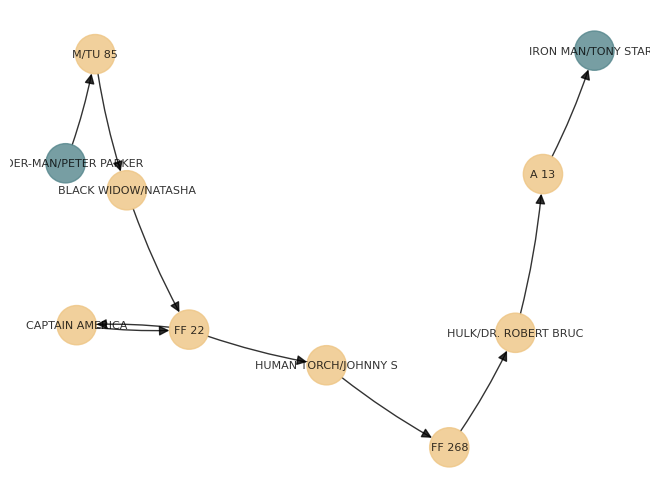

In [147]:
visualize3(G2, heroes, "SPIDER-MAN/PETER PARKER", "IRON MAN/TONY STARK",m = True)

## Functionality 5

In [186]:
'''def edge_to_removemultiple(graph):
  G_dict = nx.get_edge_attributes(graph, "weight")
  G_dict = nx.edge_betweenness_centrality(graph,weight ="weight")

  m = max(G_dict.values())

  edges = [x for x,y in G_dict.items() if y == m]

  return edges'''

'def edge_to_removemultiple(graph):\n  G_dict = nx.get_edge_attributes(graph, "weight")\n  G_dict = nx.edge_betweenness_centrality(graph,weight ="weight")\n\n  m = max(G_dict.values())\n\n  edges = [x for x,y in G_dict.items() if y == m]\n\n  return edges'

In [187]:
def edge_to_remove(graph):
  G_dict = nx.get_edge_attributes(graph, "weight")
  G_dict = nx.edge_betweenness_centrality(graph,weight ="weight")

  # extract the edge with highest edge betweenness centrality score
  edge, value = sorted(G_dict.items(), key=lambda item: item[1], reverse = True)[0]

  return edge

In [189]:
def girvan_newman(graph, n):
	# find the connected components
	sg = nx.connected_components(graph)

	# find the number of connected components
	sg_count = nx.number_connected_components(graph)

	#counter for the minimum number of edged needed to be cut to create a community
	count_edges = 0

	#while we have less than n community, we will keep on removing the edges
	while(sg_count < n):
		'''
		# Prova per togliere piu edges insime
		edges = edge_to_removemultiple(graph)

		for edge in edges:
			count_edges += 1
			graph.remove_edge(edge[0], edge[1])
		'''

		#select the edges to remove
		edge = edge_to_remove(graph)

		#increase the counter
		count_edges += 1
		#remove the edge
		graph.remove_edge(edge[0], edge[1])

		#update the connected components
		sg = nx.connected_components(graph)

		#Uptdate the number of connected components
		sg_count = nx.number_connected_components(graph)

	return sg, count_edges, graph

In [238]:
def functionality5(graph, hero1, hero2, N=None):
  #Variable used to determine if hero1 is in the same community as hero2
  sameCom = False

  #Then we find the top N Nodes/Heroes
  topN = findNHeroes(e, N)

  #Create the new subgraph from the topN heroes
  graph2 = graph.subgraph(topN)
  
  # find communities in the graph
  c, edge_count, graph_copy = girvan_newman(graph2.copy(), 2)

  #for every community in c
  node_groups = list(map(list, list(c)))

  Heroes_com = []
  #Check if hero1 and hero2 are in the same community
  for i in node_groups:
    if hero2 in i:
      Heroes_com.append(i)
    if hero1 in i:
      Heroes_com.append(i)

  return edge_count, node_groups, graph2, Heroes_com, graph_copy

## Visualization 5

In [296]:
hero1 = 'SPIDER-MAN/PETER PARKER'
hero2 = "IRON MAN/TONY STARK"
edge_count, node_groups, graph2, Heroes_com, graph_copy = functionality5(G, hero1, hero2, N = 40)

In [297]:
edge_count

123

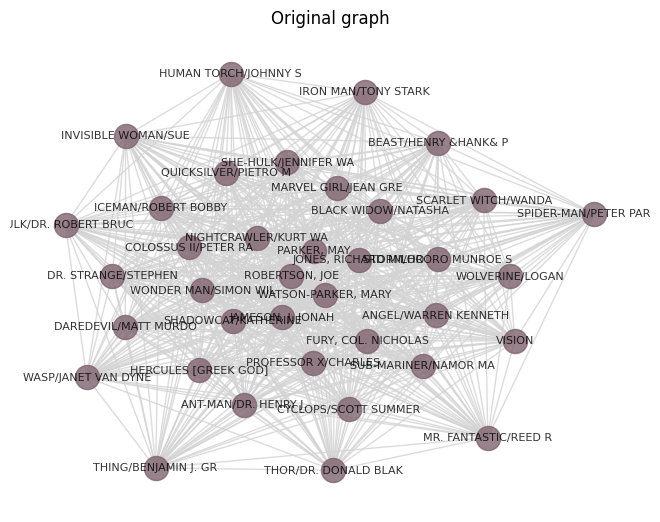

In [298]:
nx.draw(graph2, with_labels=True, pos=nx.spring_layout(graph2), font_size=8, edge_color="lightgray", node_color = "#7F636E", alpha = 0.8)
plt.title('Original graph')
plt.show()

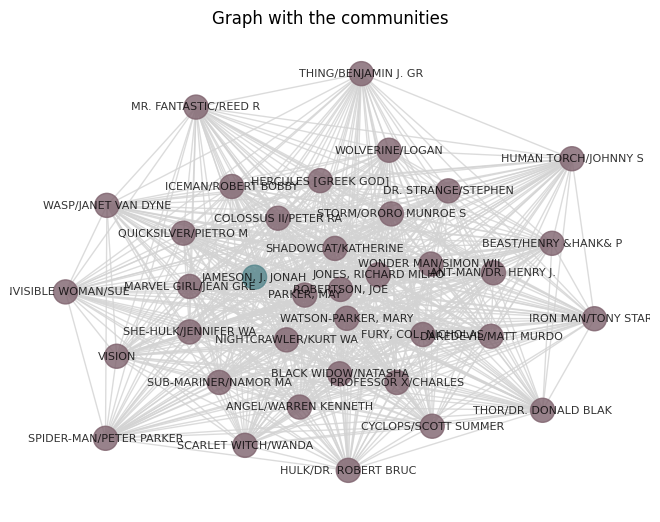

In [299]:
# plot the communities
color_map = []
for node in graph2:
    if node in node_groups[0]:
        color_map.append("#7F636E")
    elif node in node_groups[1]:
        color_map.append('#55868C')


nx.draw(graph2, node_color=color_map, with_labels=True, font_size=8, edge_color="lightgray", alpha = 0.8, pos=nx.spring_layout(graph2))
plt.title('Graph with the communities')
plt.show()

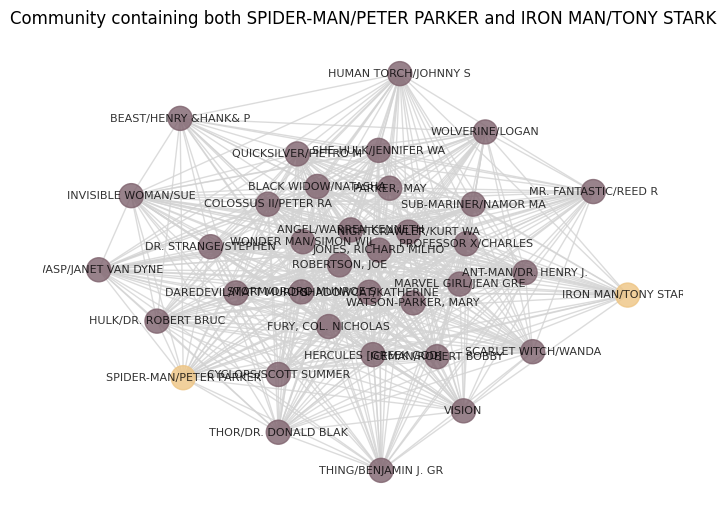

In [300]:
# plot the communities
if len(Heroes_com)==2 and Heroes_com[1] == Heroes_com[0]: 
    newG = graph_copy.subgraph(Heroes_com[0]).copy()
    node_colors = ['#EEC584' if node == hero1 else '#EEC584' if node == hero2 else "#7F636E" for node in newG]
    nx.draw(newG, with_labels=True, node_color=node_colors, pos=nx.spring_layout(newG,iterations=42), 
    font_size=8, edge_color="lightgray", alpha = 0.8)
    plt.title('Community containing both '+ str(hero1) + ' and ' +  str(hero2))
else:
    graphs = [graph_copy.subgraph(c).copy() for c in nx.connected_components(graph_copy)]

    plt.figure(figsize=(13,5))
    plt.subplot(121)

    node_colors = ['#EEC584' if node == hero1 else '#EEC584' if node == hero2 else '#55868C' for node in graphs[1]]
    nx.draw(graphs[1], with_labels=True, node_color=node_colors, pos=nx.spring_layout(graphs[1],iterations=42), 
    font_size=8, edge_color="lightgray", alpha = 0.8)

    plt.subplot(122)
    node_colors = ['#EEC584' if node == hero1 else '#EEC584' if node == hero2 else "#7F636E" for node in graphs[0]]
    nx.draw(graphs[0], with_labels=True, node_color=node_colors, pos=nx.spring_layout(graphs[0],iterations=42), 
    font_size=8, edge_color="lightgray", alpha = 0.8)
    plt.show()
    

# nx.draw(graph_copy, node_color=color_map,with_labels=True)
# plt.show()

## Command Line

In [301]:
import pandas as pd
cl_hn = pd.read_csv("hero-network.csv")
cl_e = pd.read_csv("edges.csv")

### 1

In [ ]:
cl_hn["count"] = 0
cl1 = cl_hn.groupby(by=["hero1", "hero2"]).count().sort_values(by="count")
cl1

count
hero1                hero2                      
24-HOUR MAN/EMMANUEL FROST, CARMILLA           1
MYSTERIO/QUENTIN BEC OKOYE                     1
                     OSBORN, NORMIE            1
                     PALERMO, HARRIET ROS      1
                     PALERMO, VICTOR           1
...                                          ...
THING/BENJAMIN J. GR HUMAN TORCH/JOHNNY S    382
MISS AMERICA/MADELIN PATRIOT/JEFF MACE       627
                     MISS AMERICA/MADELIN    672
PATRIOT/JEFF MACE    MISS AMERICA/MADELIN   1267
                     PATRIOT/JEFF MACE      1275

[224181 rows x 1 columns]

### 2

In [ ]:
cl2 = cl_e.groupby(by=["hero"]).count().sort_values(by="comic")
cl2

,comic
hero,
24-HOUR MAN/EMMANUEL,1
FANG,1
FANDRAL | MUTANT X-V,1
"MURRAY, WILLIAM T. B",1
TYPHOON/,1
...,...
THOR/DR. DONALD BLAK,956
THING/BENJAMIN J. GR,963
IRON MAN/TONY STARK,1150


### 3

In [ ]:
cl3 = cl_e.groupby(by=["comic"]).count().sort_values(by="hero")


cl3["hero"].sum()

96104

In [ ]:
len(cl_e.comic.unique())

12651